- Name: Vo Pham Tuan Dung
- Student 's ID: 2010013
- Dataset: ***UIT-ViCTSD***  from the paper from the paper [Constructive and Toxic Speech Detection for Open-domain Social Media Comments in Vietnamese](https://arxiv.org/pdf/2103.10069.pdf) at IEA/AIE 2021, currently stored on HuggingFace at this [link](https://huggingface.co/datasets/tarudesu/ViCTSD).


#**Autoencoder Model for Word Embedding**

#I. Import necessary things

In [113]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
%matplotlib inline

# %pip install pyvi spacy wordcloud

import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pyvi import ViTokenizer
from spacy.lang.vi import STOP_WORDS
from keras.utils import to_categorical
import torch
import pandas as pd
torch.random.manual_seed(42)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#II. Load corpus and preprocess it

In [46]:
splits = {'train': 'ViCTSD_train.csv', 'validation': 'ViCTSD_valid.csv', 'test': 'ViCTSD_test.csv'}
df = {}
for split in splits:
    df[split] = pd.read_csv("hf://datasets/tarudesu/ViCTSD/" + splits[split])

print(df['test'].info())
print(df['test'][['Topic', 'Comment']].sample(frac=1).head(10).to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Comment           1000 non-null   object
 2   Constructiveness  1000 non-null   int64 
 3   Toxicity          1000 non-null   int64 
 4   Title             1000 non-null   object
 5   Topic             1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB
None
|     | Topic     | Comment                                                                                                                                                                                                                                                                                                                                                |
|----:|:----------|:--------------------------------------------------------------------------------------

In [24]:
# # Load data
# def load_data(csv_file):
#     return pd.read_csv(csv_file, encoding="latin")
    
# train_data = load_data("Corona_NLP_train.csv").iloc[:2000]

# corpus = train_data["OriginalTweet"].to_list()
# corpus = "\n".join(corpus)
# print(corpus[:1000])

In [34]:
STOP_WORDS = set(STOP_WORDS)


def word_segment_preprocessor(texts):
    return [ViTokenizer.tokenize(text) for text in texts]


def remove_stopwords_preprocessor(texts):
    # for text in text remove all words occuring in STOP_WORDS
    return [
        " ".join([word for word in text.split() if word.lower() not in STOP_WORDS])
        for text in texts
    ]


def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b", "", text)
    # remove punctuations

    # text = re.sub("[^a-zA-Z]", " ", text) # for english
    text = re.sub(
        "[^a-zA-Zàáâãèéêìíòóôõùúýăđĩũơưạảấầẩẫậắằẳẵặẹẻẽềềểễệỉịọỏốồổỗộớờởỡợụủứừửữự]",
        " ",
        text,
    ) # for vietnamese

    # text = word_segment_preprocessor([text])[0] # word segmentation
    # text = remove_stopwords_preprocessor([text])[0] # remove stopwords
    return text


def preprocess_text(texts):
    # for vietnamese
    texts = [text_cleaner(text) for text in texts]
    texts = word_segment_preprocessor(texts) # word segmentation
    texts = remove_stopwords_preprocessor(texts) # remove stopwords
    return texts

def preprocess_corpus(texts):
    processed_texts = preprocess_text(texts)
    set_tokens = set()
    for text in processed_texts:
        set_tokens.update(text.split())
    set_tokens = sorted(list(set_tokens))
    return set_tokens

print(preprocess_corpus(["Người đàn ông mang áo sơ mi."]))

['sơ_mi', 'áo', 'đàn_ông']


In [56]:
corpus_token = dictionary = preprocess_corpus(df['train']['Comment'])

if os.path.exists("mapping.pkl"):
    print("Load mapping")
    mapping = pickle.load(open("mapping.pkl", "rb"))
else:
    print("Save mapping")
    mapping = dict((c, i) for i, c in enumerate(dictionary))
    pickle.dump(mapping, open("mapping.pkl", "wb"))

print(dictionary)

Load mapping
['a', 'a_di_da', 'a_di_dà', 'a_di_đà', 'a_phủ', 'a_tre', 'a_vậy', 'ab', 'abc', 'abcd', 'abha', 'about', 'ac', 'aca', 'acc', 'accent', 'accentchúc', 'acen', 'acetogenin', 'achen', 'acid', 'acosx', 'active', 'ad', 'adam', 'adele', 'adi', 'adidaphat', 'adn', 'ae', 'affleck', 'aflatocin', 'again', 'ah', 'ai_bảo', 'ai_ngờ', 'aicái', 'aicứ', 'aihậu', 'air', 'airbus', 'airlines', 'ajax', 'ak', 'akon', 'al', 'alaba', 'alba', 'album', 'aletico', 'alex', 'alibaba', 'all', 'alpha', 'alphonso', 'altis', 'alves', 'alzheimer', 'am', 'amazon', 'amem', 'america', 'american', 'amernia', 'amg', 'an', 'an_giang', 'an_lành', 'an_lạc', 'an_nghỉ', 'an_nhiên', 'an_nhàn', 'an_ninh', 'an_thân', 'an_toàn', 'an_tâm', 'an_yên', 'an_ủi', 'and', 'andy', 'anena', 'anfieldgriezmann', 'angelina', 'angie', 'anh_chàng', 'anh_chị', 'anh_chị_em', 'anh_dũng', 'anh_em', 'anh_hùng', 'anh_trai', 'anh_ách', 'anhchúc', 'anhcoutinho', 'aniston', 'annonacin', 'ansu', 'anten', 'anti', 'antifan', 'ao', 'ao_ước', 'aod',

#III. Convert corpus to one-hot vectors & Define embedding dim

In [53]:
embedding_dim = 256
vocab_size = len(dictionary)
print(vocab_size)

10624


In [58]:
corpus_encode = [mapping[x] for x in corpus_token]
onehot_corpus = keras.utils.to_categorical(corpus_encode, num_classes=vocab_size)
print(onehot_corpus)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#IV. Define Autoencoder model

In [59]:
ae_model = keras.Sequential()
ae_model.add(keras.Input(shape=(vocab_size,)))
ae_model.add(keras.layers.Dense(embedding_dim, activation='relu'))
ae_model.add(keras.layers.Dense(vocab_size, activation='softmax'))

ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

if os.path.exists("ae_model.h5"):
  ae_model.load_weights("ae_model.h5")

ae_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2720000   
                                                                 
 dense_1 (Dense)             (None, 10624)             2730368   
                                                                 
Total params: 5,450,368
Trainable params: 5,450,368
Non-trainable params: 0
_________________________________________________________________


#V. Train AE model

In [60]:
# Train model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ae_model.h5", monitor='val_loss', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

ae_model.fit(x=onehot_corpus, y=onehot_corpus, batch_size=512, epochs=1000,
          validation_split=0.2, validation_freq=1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb],
          workers=1, use_multiprocessing=False)

ae_model.save("ae_model.h5")

Epoch 1/1000
17/17 [==============================] - 4s 132ms/step - loss: 9.2744 - accuracy: 0.0000e+00 - val_loss: 9.2812 - val_accuracy: 0.0000e+00
Epoch 2/1000
17/17 [==============================] - 0s 28ms/step - loss: 9.2552 - accuracy: 0.2125 - val_loss: 9.3076 - val_accuracy: 0.0000e+00
Epoch 3/1000
17/17 [==============================] - 2s 99ms/step - loss: 9.2215 - accuracy: 0.2849 - val_loss: 9.3926 - val_accuracy: 0.0000e+00
Epoch 4/1000
17/17 [==============================] - 0s 28ms/step - loss: 9.1592 - accuracy: 0.3362 - val_loss: 9.6033 - val_accuracy: 0.0000e+00
Epoch 5/1000
17/17 [==============================] - 1s 31ms/step - loss: 9.0704 - accuracy: 0.2598 - val_loss: 10.0114 - val_accuracy: 0.0000e+00
Epoch 6/1000
17/17 [==============================] - 1s 83ms/step - loss: 8.9741 - accuracy: 0.1803 - val_loss: 10.5640 - val_accuracy: 0.0000e+00
Epoch 7/1000
17/17 [==============================] - 0s 28ms/step - loss: 8.8856 - accuracy: 0.1996 - val_loss

In [112]:
onehot_corpus.shape

(10624, 10624)

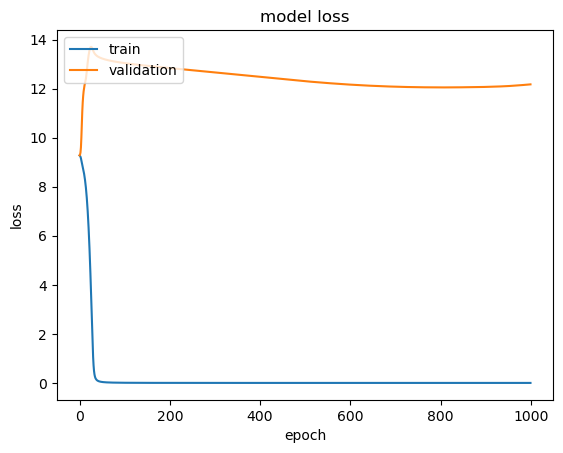

In [61]:
# draw line of validation loss
history = ae_model.history.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



#=======================================================================

# **How to use trained model**

#=======================================================================

#VI. Load trained model & Get output of 1st FC layer

In [62]:
reconstructed_model = keras.models.load_model("ae_model.h5")
we_model = keras.models.Model(inputs=reconstructed_model.inputs, outputs=reconstructed_model.get_layer('dense').output)

Define function to encode one-hot list of words

In [63]:
def encode_onehot(mapping, list_words):
  output = []
  
  for word in list_words:
    word_vector = [0 for _ in range(vocab_size)]

    if word in mapping.keys():
      word_index = mapping[word]
      word_vector[word_index] = 1
    
    output.append(word_vector)
  
  return output

#VII. Test model

In [64]:
input_sentence = '''
Messi là một cầu thủ. Talor Swift là một ca sĩ. 
Messi đá bóng. Talor Swift hát. 
Messi biểu diễn trên sân cỏ. Talor Swift biểu diễn trên sân khấu.
'''

preprocess_sentence = preprocess_text(input_sentence)
onehot_sentence = encode_onehot(mapping, preprocess_sentence)

embedded_sentence = we_model.predict(onehot_sentence)
print(embedded_sentence)

5/5 [==============================] - 0s 2ms/step
[[0.3181851  0.31548443 0.31414706 ... 0.31615996 0.3081477  0.3144132 ]
 [0.07135892 0.57476175 0.02166659 ... 0.5898416  0.5696223  0.5895597 ]
 [0.03009915 0.5840391  0.0109244  ... 0.5964334  0.569134   0.5795499 ]
 ...
 [0.33088803 0.29577008 0.3137799  ... 0.31577373 0.2989314  0.32998478]
 [0.3181851  0.31548443 0.31414706 ... 0.31615996 0.3081477  0.3144132 ]
 [0.3181851  0.31548443 0.31414706 ... 0.31615996 0.3081477  0.3144132 ]]


In [108]:
word_0 = "cầu thủ"
word_1 = "đàn bà"
word_2 = "đàn ông"

preprocess_words = preprocess_text([word_0, word_1, word_2])
onehot_words = encode_onehot(mapping, preprocess_words)
print(preprocess_words)

embeddings = we_model.predict(onehot_words)
word_0_eb, word_1_eb, word_2_eb = embeddings[0], embeddings[1], embeddings[2]

# print("OUTPUT EMBEDDING")
# print(word_0_eb)
# print(word_1_eb)
# print(word_2_eb)

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

['cầu_thủ', 'đàn_bà', 'đàn_ông']
1/1 [==============================] - 1s 760ms/step
OUTPUT DISTANCE
0 vs 1:  4.472612380981445
1 vs 2:  0.3003937005996704
2 vs 0:  4.454265594482422


1/1 [==============================] - 0s 174ms/step


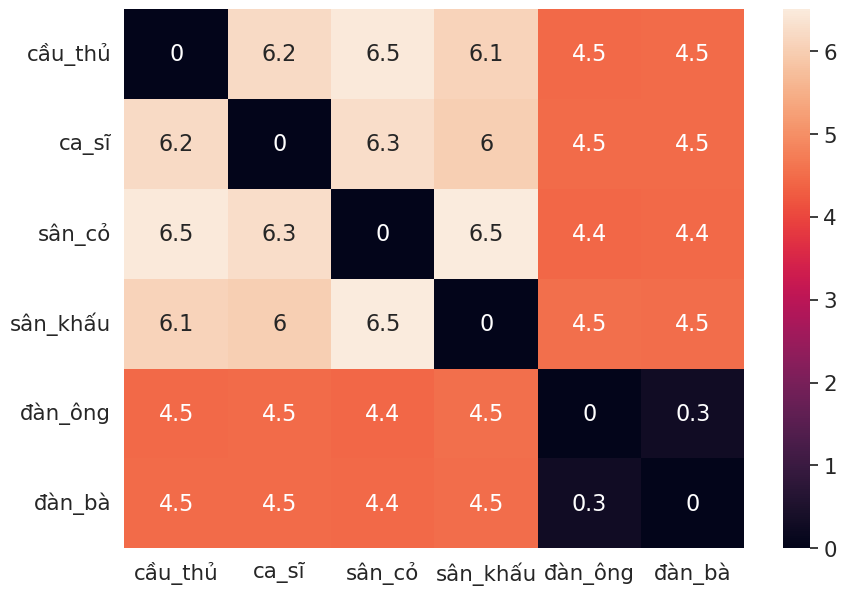

In [111]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ['cầu_thủ', 'ca_sĩ', 'sân_cỏ', 'sân_khấu', 'đàn_ông', 'đàn_bà']
onehot_words = encode_onehot(mapping, list_words)
list_word_embs = we_model.predict(onehot_words)

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}
           ) # font size

plt.show()